## Exploration

Started off with looking at a very simple PCA rendition of the data. Even with no tweaking, there was a distinct divide between non-events and events. I decided to start testing an SVM model, since the divide looked like it could be modeled quite well with a polynomial kernel SVM.

### Prepping the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

npf = pd.read_csv('npf_train.csv')
npf["class4"] = npf["class4"].astype("category")
npf = npf.drop("id",axis=1)
npf = npf.drop("partlybad",axis=1)
npf = npf.drop("date",axis=1)

Y = npf['class4']
Y_bin = npf['class4'].map({'nonevent': 'nonevent', 'Ia': 'event', 'Ib': 'event', 'II': 'event'})
X = npf.drop('class4', 1)

print(X.columns)

Index(['CO2168.mean', 'CO2168.std', 'CO2336.mean', 'CO2336.std', 'CO242.mean',
       'CO242.std', 'CO2504.mean', 'CO2504.std', 'Glob.mean', 'Glob.std',
       'H2O168.mean', 'H2O168.std', 'H2O336.mean', 'H2O336.std', 'H2O42.mean',
       'H2O42.std', 'H2O504.mean', 'H2O504.std', 'H2O672.mean', 'H2O672.std',
       'H2O84.mean', 'H2O84.std', 'NET.mean', 'NET.std', 'NO168.mean',
       'NO168.std', 'NO336.mean', 'NO336.std', 'NO42.mean', 'NO42.std',
       'NO504.mean', 'NO504.std', 'NO672.mean', 'NO672.std', 'NO84.mean',
       'NO84.std', 'NOx168.mean', 'NOx168.std', 'NOx336.mean', 'NOx336.std',
       'NOx42.mean', 'NOx42.std', 'NOx504.mean', 'NOx504.std', 'NOx672.mean',
       'NOx672.std', 'NOx84.mean', 'NOx84.std', 'O3168.mean', 'O3168.std',
       'O342.mean', 'O342.std', 'O3504.mean', 'O3504.std', 'O3672.mean',
       'O3672.std', 'O384.mean', 'O384.std', 'Pamb0.mean', 'Pamb0.std',
       'PAR.mean', 'PAR.std', 'PTG.mean', 'PTG.std', 'RGlob.mean', 'RGlob.std',
       'RHIRGA168.

### First test with no optimizations

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf = SVC(kernel='poly', degree=3)
scores = cross_val_score(clf, X, Y, cv=3)
scores

array([0.58169935, 0.58169935, 0.55263158])

Ok, multiclass performance was bad. But I'm more interested in binary classification.

In [18]:
clf = SVC(kernel='poly', degree=3)
scores = cross_val_score(clf, X, Y_bin, cv=3)
scores

array([0.80392157, 0.77124183, 0.74342105])

Still quite bad but let's start improving on it.

### Feature selection

Plotting a correlation matrix shows that the data has clear patterns of correlation.

Linear correlation


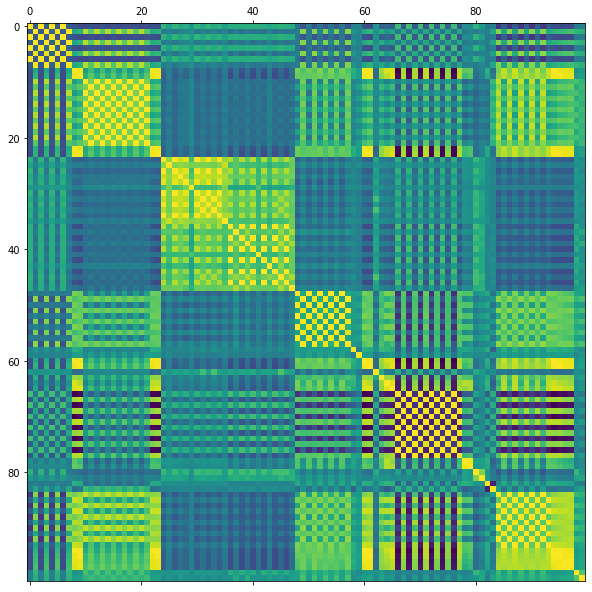

Spearman correlation


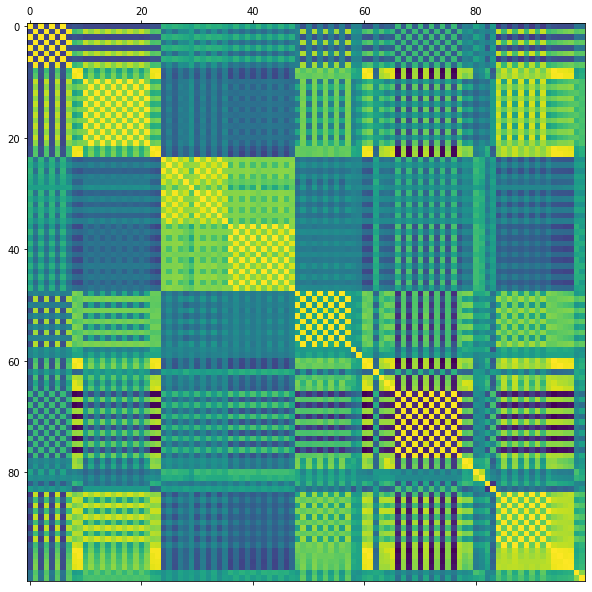

In [49]:
X = npf.drop("class4", 1)

print('Linear correlation')
plt.figure(figsize=(10,10))
corr_pearson = X.corr(method='pearson')
plt.matshow(corr_pearson, fignum=1)
plt.show()

print('Spearman correlation')
plt.figure(figsize=(10,10))
corr_spearman = X.corr(method='spearman')
plt.matshow(corr_spearman, fignum=1)
plt.show()

The plots look very similar.

In [71]:
from pysat.examples.rc2 import RC2
from pysat.formula import WCNF

def compile_suitable_columns(wcnf):
    # this is essentially a MAX-2SAT problem of form
    # (column1 or column2) and (column1 or column3) and ...
    # essentially going through all column pairs with strong correlation
    # which we can only choose 1 out of
    with RC2(wcnf) as rc2:
        for m in rc2.enumerate():
            print('model {0} has cost {1}'.format(m, rc2.cost))
        return rc2
    return []

def get_column_names(threshold):
    corr_spearman_np = corr_spearman.to_numpy()
    cols = np.argwhere(np.abs(corr_spearman_np) > threshold)
    wcnf = WCNF()
    for row in cols:
        x1 = (row[0] + 1).item()
        x2 = (row[1] + 1).item()
        wcnf.extend([[-x1, x2], [x1, -x2], [-x1, -x2]], weights=[10, 10, 1])
    wcnf.to_file('correlation.wcnf')
    return compile_suitable_columns(wcnf)

cols = get_column_names(0.5)
cols

# result from overnight run
# [-1, -2, 3, -4, 5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, 59, 60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, -82, 83, 84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100]

model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] has cost 0
model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, 63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99

model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, -82, -83, 84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] has cost 21
model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, 82, -83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99

model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, 63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, 82, 83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] has cost 26
model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, 59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, 82, 83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100

model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, -82, -83, 84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] has cost 42
model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, 59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, 82, 83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -

model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, 59, 60, -61, -62, 63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, -82, -83, 84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] has cost 45
model [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, 59, 60, -61, -62, 63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, -82, 83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] 

model [-1, -2, -3, -4, 5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, 59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, 82, 83, 84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] has cost 170
model [-1, -2, -3, -4, 5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, 60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, 81, 82, 83, 84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100] h

KeyboardInterrupt: 

### Getting best heights per type

In [46]:
type_names = ['CO2', 'H2O', 'NO', 'NOx', 'O3', 'RHIRGA', 'T']

def calc_difference(x):
    baseline = x['nonevent']
    return x - baseline

def calc_percentage(mean):
    def calc(x):
        per_values = pd.Series([(x[col] / mean[col]) * 100 for col in x.index], index=[f'{col}_per' for col in x.index])
        return x.append(per_values)
    return calc

for name in type_names:
    df = npf.filter(regex=f'^{name}\d+|class4')
    df_means = df.filter(regex='mean|class4')
    df_std = df.filter(regex='std|class4')
    mean = df.mean()
    means_data = df_means.groupby('class4').mean().apply(calc_difference, axis=0).apply(calc_percentage(mean), axis=1, result_type='expand')
    std_data = df_std.groupby('class4').mean().apply(calc_difference, axis=0).apply(calc_percentage(mean), axis=1, result_type='expand')
    print(name)
    print(means_data)
    print(std_data)
    print()

CO2
          CO2168.mean  CO2336.mean  CO242.mean  CO2504.mean  CO2168.mean_per  \
class4                                                                         
II          -3.544103    -3.465569   -3.778270    -3.426843        -0.930220   
Ia          -5.927397    -5.829605   -6.290940    -5.753385        -1.555762   
Ib          -5.787165    -5.697367   -5.934367    -5.650284        -1.518956   
nonevent     0.000000     0.000000    0.000000     0.000000         0.000000   

          CO2336.mean_per  CO242.mean_per  CO2504.mean_per  
class4                                                      
II              -0.909564       -0.989318        -0.899639  
Ia              -1.530023       -1.647246        -1.510418  
Ib              -1.495316       -1.553879        -1.483351  
nonevent         0.000000        0.000000         0.000000  
          CO2168.std  CO2336.std  CO242.std  CO2504.std  CO2168.std_per  \
class4                                                                    

* Height doesn't really matter for anything but O3 and RHIRGA, for both lowest is best
* Ia seems to have a lower standard deviation for most of these values
* CO2.mean seems to not have a big difference between classes, others matter

### Looking at other classes

In [47]:
type_names2 = ['Glob', 'NET', 'Pamb0', 'PAR', 'PTG', 'RGlob', 'RPAR', 'SO2', 'SWS', 'UV_A', 'UV_B', 'CS']

for name in type_names2:
    df = npf.filter(regex=f'^{name}|class4')
    df_means = df.filter(regex='mean|class4')
    df_std = df.filter(regex='std|class4')
    mean = df.mean()
    means_data = df_means.groupby('class4').mean().apply(calc_difference, axis=0).apply(calc_percentage(mean), axis=1, result_type='expand')
    std_data = df_std.groupby('class4').mean().apply(calc_difference, axis=0).apply(calc_percentage(mean), axis=1, result_type='expand')
    print(name)
    print(means_data)
    print(std_data)
    print()

Glob
           Glob.mean  Glob.mean_per
class4                             
II        141.227107      73.065667
Ia         93.267123      48.252950
Ib        149.651894      77.424339
nonevent    0.000000       0.000000
           Glob.std  Glob.std_per
class4                           
II        96.003936     65.949617
Ia        47.924613     32.921670
Ib        97.221641     66.786116
nonevent   0.000000      0.000000

NET
           NET.mean  NET.mean_per
class4                           
II        87.307582     71.335047
Ia        48.015153     39.230993
Ib        91.163996     74.485947
nonevent   0.000000      0.000000
            NET.std  NET.std_per
class4                          
II        86.887494    67.816286
Ia        45.376092    35.416351
Ib        84.810201    66.194944
nonevent   0.000000     0.000000

Pamb0
          Pamb0.mean  Pamb0.mean_per
class4                              
II          2.860504        0.288561
Ia          3.509189        0.353999
Ib          4

* Pamb0.mean, SWS.mean doesn't seems to have much of an effect
* PTG.mean extremely different

### Choosing columns
Based on the notes above, I decided to go for the following columns

In [ ]:
picked_columns = [ 
    'CO2168.std', 'Glob.mean', 'Glob.std',
    'H2O168.mean', 'H2O168.std', 'NET.mean', 'NET.std', 'NO168.mean',
    'NO168.std', 'NOx168.mean', 'NOx168.std', 'O3168.mean', 'O3168.std',
    'O342.mean', 'O342.std', 'Pamb0.std',
    'PAR.mean', 'PAR.std', 'PTG.mean', 'PTG.std', 'RGlob.mean', 'RGlob.std',
    'RHIRGA42.mean', 'RHIRGA42.std', 
    'RPAR.mean', 'RPAR.std', 'SO2168.mean', 'SO2168.std',
    'SWS.std', 'T42.mean', 'T42.std', 'UV_A.mean',
    'UV_A.std', 'UV_B.mean', 'UV_B.std', 'CS.mean', 'CS.std'
]

new_X = X[picked_columns]
new_X_with_class = npf[picked_columns + ['class4']]

plt.figure(figsize=(36,36))
sns.pairplot(new_X_with_class,hue="class4",vars=new_X_with_class.columns,kind="reg")

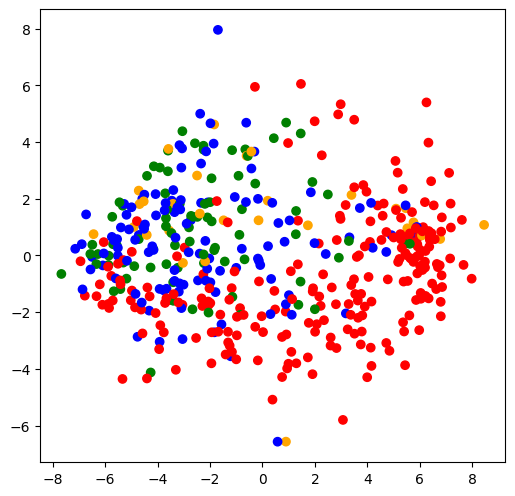

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(6, 6), dpi=100)

def color(label):
    if label == 'nonevent':
        return 'red'
    if label == 'II':
        return 'blue'
    if label == 'Ia':
        return 'orange'
    if label == 'Ib':
        return 'green'

Y_colors = [color(y) for y in list(Y)] 

clf = SVC(kernel='rbf')
scaled = StandardScaler().fit(new_X)
pca = PCA(n_components=2).fit_transform(scaled.transform(new_X))
plt.scatter(pca[:,0],pca[:,1],color=Y_colors)

#scores = cross_val_score(clf, pca, Y, cv=3)
#scores

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
scores = cross_val_score(clf, new_X, Y, cv=3)
scores

array([0.61437908, 0.63398693, 0.65131579])

In [16]:
# I wanna try binary classification just by PTG.mean
clf = RandomForestClassifier()
scores = cross_val_score(clf, X[['PTG.mean']], Y_bin, cv=3)
scores

array([0.55555556, 0.5751634 , 0.68421053])

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=100)
scores = cross_val_score(clf, new_X, Y, cv=3)
scores

d:\program files\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\program files\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

array([0.60130719, 0.50326797, 0.57894737])

In [9]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
scores = cross_val_score(clf, new_X, Y, cv=3)
scores

array([0.56862745, 0.44444444, 0.50657895])

Guess we could start optimizing a random forest classifier

In [ ]:
plt.scatter()